<a href="https://colab.research.google.com/github/Jollyhrothgar/deep_learning/blob/master/Simple%20Mean%20regression%20vs%20Simple%20Neural%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

Following tutorial [here](https://www.tensorflow.org/tutorials/keras/classification)

* Check out tensorflow.data - load data in here, and you can train more efficiently, leveraging functions that augment images.

In [3]:
!pip install pandas
!pip install seaborn
!pip install scipy
!pip install matplotlib
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter

In [5]:
print(tf.__version__)

2.3.0


In [6]:
# Grab a data set from keras data sets.
fashion_mnist = keras.datasets.fashion_mnist

# Define the numan readable class-names:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# The index of class_names correponds to the numeric value of the class-label

In [7]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


# Data Exploration

Training and testing data here are represented as `28x28` grids of numbers, with the associated label. Array order is preserved for testing/training data and labels.*italicized text*

In [8]:
# Training / Testing Examples:
print("Train: {}, Test: {}, Ratio: {:.2f}".format(len(train_images), len(test_images), len(test_images)/len(train_images)))

Train: 60000, Test: 10000, Ratio: 0.17


# Randomly Sample The Input Data

We can get a sense of both the make-up and the variance of the data by randomly sampling and looking at it. This is not technical in the least.

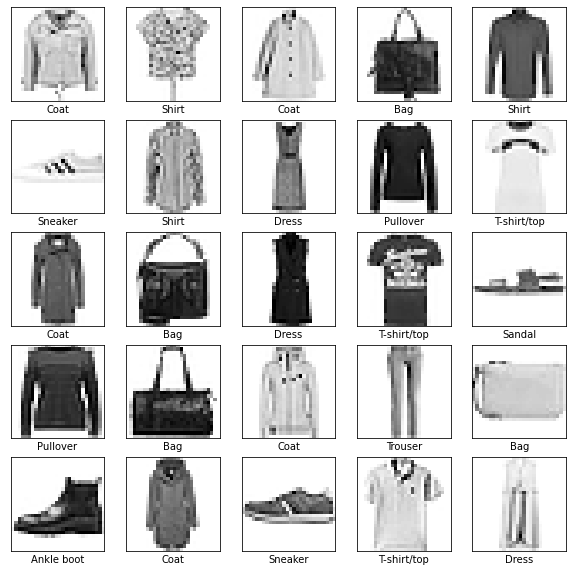

In [9]:
# Examine Some Images
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  idx = np.random.randint(low=0, high=len(train_images))
  plt.imshow(train_images[idx], cmap='Greys')
  plt.xlabel(class_names[train_labels[idx]])

## Normalize the Data

In [10]:
# To prepare the data for the neural network, we are supposed to normalize it.
# Since each image has a pixel value between 0 and 255, we divide by 255.
train_images_normed = train_images / 255.0
test_images_normed = test_images / 255.0

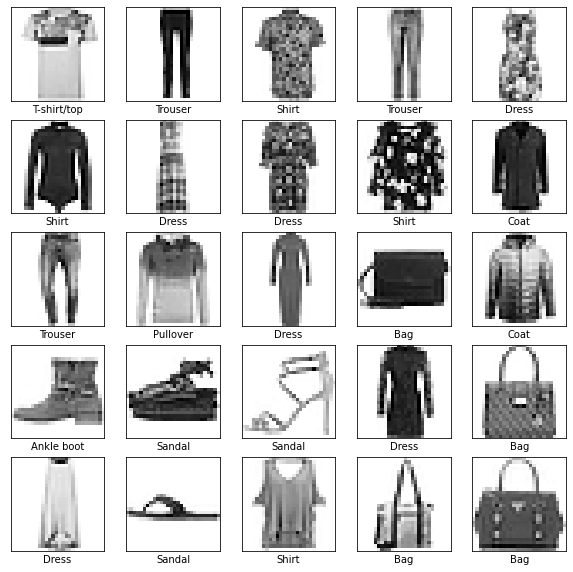

In [11]:
# Confirm we didn't break anything:
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  idx = np.random.randint(low=0, high=len(train_images))
  plt.imshow(train_images[idx], cmap='Greys')
  plt.xlabel(class_names[train_labels[idx]])

## Exploring Data - Taking Averages

An interesting thought occured to me - what if I take the average of all the images of a particular class and then see what the image looks like?

In [12]:
# For funzies, what does the average boot look like?
df = pd.DataFrame(list(zip(train_images_normed, train_labels)), columns=['img', 'label'])
df['label'] = df['label'].apply(lambda x: class_names[x])
df.head()

,img,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Ankle boot
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098...",T-shirt/top
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",T-shirt/top
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12...",Dress
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",T-shirt/top


Characteristics of each clothing class emerge - clear boundaries outlining anything are indicative of a highly curated data set.

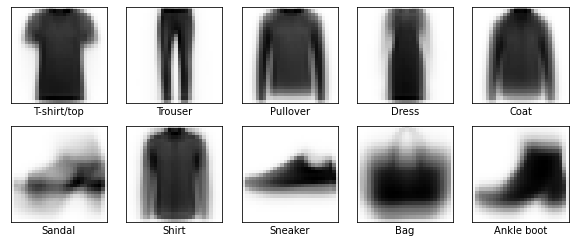

In [13]:
plt.figure(figsize=(10,4))
mean_regression_model = {}
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  average_class = df[df['label'] == class_names[i]]['img'].mean()
  mean_regression_model[class_names[i]] = average_class
      
  plt.imshow(mean_regression_model[class_names[i]], cmap='Greys')

  plt.xlabel(class_names[i])

As the container hints, when we have taken the average of images, we have what is called a "mean regression model". Because of how well behaved the training data set is, we should expect this model to perform reasonably well as a baseline. In the real world, we might not be able to generalize the training data to the point where we can guarantee its perfectly centered, well-lit, flat, non-rotated, etc. However, this could also be part of a cleaning process.

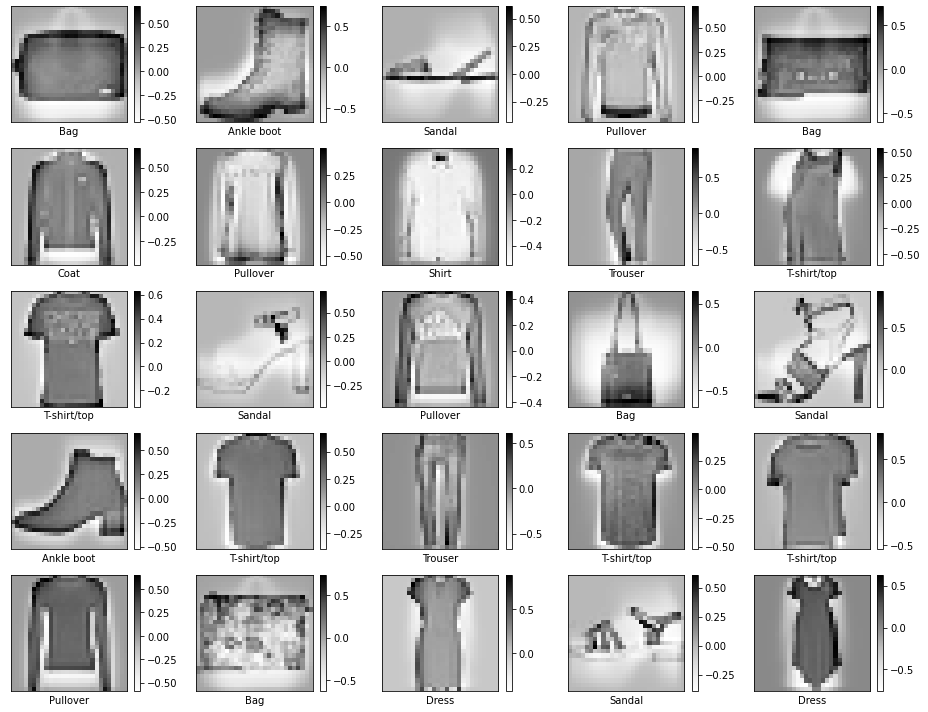

In [14]:
# Look at residuals - randomly sample 25 more items from the training set and
# calculate the residual image (subtracting the mean image from the real image.)
plt.figure(figsize=(13, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  idx = np.random.randint(low=0, high=len(train_images))
  plt.imshow(train_images_normed[idx] - mean_regression_model[class_names[train_labels[idx]]], cmap='Greys')
  plt.xlabel(class_names[train_labels[idx]])
  plt.colorbar()
plt.tight_layout()

## Gausssian Filtering

If we wanted to go all-in with mean-regression, we might get better performance if we could transform the input data to look more like what the model is looking for. One way we could do that is to use gaussian filtering, to make the image look blurrier, blobbier. Who knows if it helps...

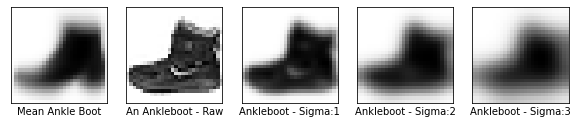

In [15]:
# Try out gassuan filtering - perhaps this is a good regularization technique?
plt.figure(figsize=(10, 4))

# Boot.
plt.subplot(2, 5, 1)
plt.imshow(mean_regression_model[class_names[9]], cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.xlabel('Mean Ankle Boot')

plt.subplot(2, 5, 2)
plt.imshow(train_images_normed[0], cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.xlabel("An Ankleboot - Raw")

for i in range(2,5):

  plt.subplot(2, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  plt.imshow(gaussian_filter(train_images_normed[0], sigma=i-1), cmap='Greys')
  plt.xlabel("Ankleboot - Sigma:{}".format(i-1))


In [16]:
# Blobby Prediction vs Non Blobby Prediction?

## Making Predictions With Mean Regression

Now that we've 'trained' a mean regression model, we can go ahead and try 'predicting' each class, ordering the root-mean-square of the residual image to assign a prediction. First place gets it (lowest residual).


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Sneaker'),
  Text(1, 0, 'Sandal'),
  Text(2, 0, 'Ankle boot'),
  Text(3, 0, 'Bag'),
  Text(4, 0, 'Shirt'),
  Text(5, 0, 'Dress'),
  Text(6, 0, 'Trouser'),
  Text(7, 0, 'T-shirt/top'),
  Text(8, 0, 'Pullover'),
  Text(9, 0, 'Coat')])

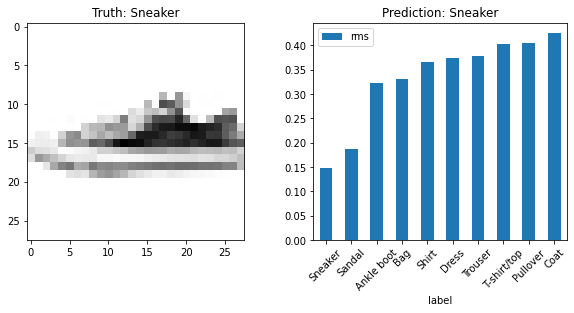

In [17]:
# Try out the mean regressor (for funzies)
idx = np.random.randint(low=0, high=len(train_images))
example = train_images_normed[idx]
fig = plt.figure(figsize=(10,4))

def predict_mean_regression(model, img):
  rms_values = []
  for label in model.keys():
    residual = img - model[label]
    rms = np.power(np.power(residual, 2).mean(), 0.5)
    rms_values.append(rms)
  
  df = pd.DataFrame(list(zip(class_names, rms_values)), columns=['label', 'rms'])
  df.set_index('label', inplace=True)
  df.sort_values(by='rms', ascending=True, inplace=True)

  label = df.iloc[0].name

  return df, label
  
plt_df, label = predict_mean_regression(model=mean_regression_model, img=example)
plt.subplot(1, 2, 1)
plt.imshow(example, cmap='Greys')
plt.title("Truth: {}".format(class_names[train_labels[idx]]))
plt.subplot(1, 2, 2)
ax = fig.get_axes()
plt_df.plot.bar(ax=ax[1])
ax[1].set_title('Prediction: {}'.format(plt_df.iloc[0].name))
plt.xticks(rotation=45)

In [18]:
# Total Accuracy
correct = 0
incorrect = 0


for idx, test_img in enumerate(test_images_normed):
  example = test_img
  rms_values = []
  for label in class_names:
    residual = example - mean_regression_model[label]
    rms = np.power(np.power(residual, 2).mean(), 0.5)
    rms_values.append(rms)
  
  plt_df = pd.DataFrame(list(zip(class_names, rms_values)), columns=['label', 'rms'])
  plt_df.set_index('label', inplace=True)
  plt_df.sort_values(by='rms', ascending=True, inplace=True)
  
  truth = class_names[test_labels[idx]]
  predict = plt_df.iloc[0].name

  if truth == predict:
    correct += 1
  else:
    incorrect += 1

print("Correct: {}, Incorrect: {}, Accuracy: {:.2f}%".format(correct, incorrect, 100*(correct/(correct+incorrect))))

Correct: 6768, Incorrect: 3232, Accuracy: 67.68%


### Summary of Mean Regression

So, not too shabby, considering we're just taking averages here. We got almost 70% accuracte, when guessing randomly (assuming even class distribution) would net us only 1/10 (10%).

In [19]:
print("Test Class Distribution", pd.Series(data=test_labels).value_counts())
print("Train Class Distribution", pd.Series(data=train_labels).value_counts())

Test Class Distribution 7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
dtype: int64
Train Class Distribution 9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64


# Neural Networks

Now, we go ahead with the scary part...a neural network! AIiieeee!

Layer extract representations of data by successively combining the features via multiplication + transformation until we've arrived at the best combination of neuronal weights.

Here, we do:

```python
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])
```

* `tf.keras.layers.Flatten` transforms the image from  28 by 28 to one-dimension of $28 \times 28 = 784.

* `tf.keras.layers.Dense` defines a layer type which contains densely connected neurons (every neuron between each layer conntects with every neuron in the next layer).

* `tf.keras.layers.Dense` final layer uses default logit type neurons (for classification) returning the probability of each class.

We've defined the architecture of the neural network in terms an input layer, "hidden layers" and the output layer - a 10-dim vector representing the probability of each class. We have one input layer, a single fully connected hidden layer, and an output layer.

Once the topology of the network is defined, we have to specify the means by which the model will be trained:

* A **loss-function**: measuring how the model calculates the cost of getting the wrong prediction. This is optimized (minimized) by the optimizer.
* An **optimizer**: This performs the proceedure which moves the weights of the network along the loss-surface to try and get to a global minimum.
* **Metrics**: this defines what kind of classification accuracy is used to tune the mode

We specify this configuration, compile the modeel, and then train it.

The output layer is a "logit" which basically just means a vector of raw (non-normalized) predictions that a classification model generates. Typically these outputs are passed to a normalization function. Logits can refer to an element-wise inverse of the sigmoid function.

In [20]:
# Specify network layers
model = keras.Sequential(layers=[
  keras.layers.Flatten(input_shape=(28, 28)),
  # Model API: can pull this layer out and visualize the clustering (for
  # example, use the functional API)
  keras.layers.Dense(128, activation='relu'), # output here
  keras.layers.Dense(10)
])

# Specify network configuration
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [21]:
history = model.fit(train_images_normed, train_labels, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5052 - accuracy: 0.8201
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3787 - accuracy: 0.8631
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3406 - accuracy: 0.8771
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3155 - accuracy: 0.8859
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2980 - accuracy: 0.8904
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2805 - accuracy: 0.8961
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2683 - accuracy: 0.9005
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2590 - accuracy: 0.9038
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2490 - accuracy: 0.9068
Epoch 10/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.240

In [22]:
history = pd.DataFrame(
  list(zip(history.history['loss'], history.history['accuracy'], history.epoch)),
  columns=['loss', 'accuracy', 'epochs']
).set_index('epochs')

Text(0.5, 1.0, 'Train Accuracy')

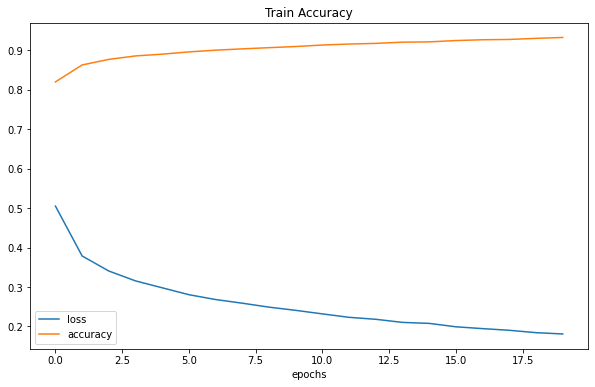

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
history.plot(ax=ax)
ax.set_title("Train Accuracy")

In [24]:
# Evaluate Test Accuracy
test_loss, test_acc = model.evaluate(test_images_normed, test_labels, verbose=2)
print("Test Accuracy:", test_acc)

313/313 - 0s - loss: 0.3833 - accuracy: 0.8857
Test Accuracy: 0.885699987411499


Because the model performs a bit worse on the test set, this indicates it has slightly overfit to the training set. Lets presume that we are satisfied with the difference between the train set and the test set for now.

We can trasform the model into a probability model by adding in another layer - softmax, to convert the logits to probabilities.

In [25]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images_normed)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Pullover'),
  Text(1, 0, 'Coat'),
  Text(2, 0, 'Shirt'),
  Text(3, 0, 'Bag'),
  Text(4, 0, 'T-shirt/top'),
  Text(5, 0, 'Dress'),
  Text(6, 0, 'Ankle boot'),
  Text(7, 0, 'Trouser'),
  Text(8, 0, 'Sneaker'),
  Text(9, 0, 'Sandal')])

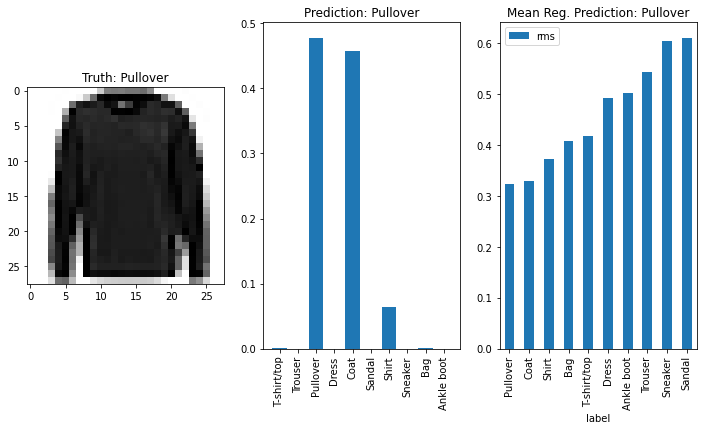

In [26]:
# Rerun this cell to generate random predictions.
idx = np.random.randint(low=0, high=len(test_images_normed))
truth  = class_names[test_labels[idx]]
prediction = class_names[np.argmax(predictions[idx])]
img = test_images_normed[idx]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
plt.sca(ax[0])
plt.imshow(img, cmap='Greys')

ax[1].bar(class_names, predictions[idx])
ax[0].set_title('Truth: {}'.format(truth))
ax[1].set_title('Prediction: {}'.format(prediction))
plt.sca(ax[1])
plt.xticks(rotation=90)

df, label = predict_mean_regression(model=mean_regression_model, img=test_images_normed[idx])
df.plot.bar(ax=ax[2])
ax[2].set_title('Mean Reg. Prediction: {}'.format(label))
plt.sca(ax[2])
plt.xticks(rotation=90)
